# 여성 계절 분류를 위한 모델 생성 코드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# 학습에 사용할 데이터 불러오기

In [ ]:
image_dir = Path('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Season/woman')

In [ ]:
image_dir

PosixPath('/content/drive/MyDrive/2023 KUIAI 해커톤/Data/Season/woman')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [ ]:
images

,Filepath,Label
0,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
1,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
2,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
3,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
4,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,spring
...,...,...
1912,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter
1913,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter
1914,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter
1915,/content/drive/MyDrive/2023 KUIAI 해커톤/Data...,winter


In [ ]:
images.Label.value_counts()

summer    713
winter    619
autumn    484
spring    101
Name: Label, dtype: int64

# Train / Test Split & 모델 신경망 구축 by Resnet50 with pretrained layer 호출

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1073 validated image filenames belonging to 4 classes.
Found 268 validated image filenames belonging to 4 classes.
Found 576 validated image filenames belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(
                    input_shape=(224, 224, 3),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg')

pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# 모델 학습 with Early Stopping / Epoch : 25

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
history = model.fit(train_images,validation_data=val_images,epochs=25,callbacks=[callbacks])


Epoch 1/25
34/34 [==============================] - 240s 7s/step - loss: 0.9551 - accuracy: 0.5974 - val_loss: 0.7300 - val_accuracy: 0.6940
Epoch 2/25
34/34 [==============================] - 206s 6s/step - loss: 0.6982 - accuracy: 0.7111 - val_loss: 0.7160 - val_accuracy: 0.7239
Epoch 3/25
34/34 [==============================] - 206s 6s/step - loss: 0.5873 - accuracy: 0.7679 - val_loss: 0.7360 - val_accuracy: 0.7201
Epoch 4/25
34/34 [==============================] - 206s 6s/step - loss: 0.5419 - accuracy: 0.7903 - val_loss: 0.6446 - val_accuracy: 0.7612
Epoch 5/25
34/34 [==============================] - 206s 6s/step - loss: 0.4627 - accuracy: 0.8276 - val_loss: 0.7139 - val_accuracy: 0.7425
Epoch 6/25
34/34 [==============================] - 209s 6s/step - loss: 0.4428 - accuracy: 0.8295 - val_loss: 0.7128 - val_accuracy: 0.7351
Epoch 7/25
34/34 [==============================] - 207s 6s/step - loss: 0.3554 - accuracy: 0.8621 - val_loss: 0.7434 - val_accuracy: 0.7276


In [ ]:
results = model.evaluate(test_images, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[0.6858417987823486, 0.7222222089767456]
Test Accuracy: 72.22%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)
matrix = confusion_matrix(test_images.labels, predictions)
report= classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

18/18 [==============================] - 89s 5s/step


In [ ]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [ ]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      autumn       0.58      0.44      0.50       146
      spring       1.00      0.03      0.06        32
      summer       0.77      0.91      0.83       211
      winter       0.73      0.86      0.79       187

    accuracy                           0.72       576
   macro avg       0.77      0.56      0.55       576
weighted avg       0.72      0.72      0.69       576



In [ ]:
data_his = pd.DataFrame(history.history)
data_his

,loss,accuracy,val_loss,val_accuracy
0,0.955108,0.597390,0.729955,0.694030
1,0.698228,0.711090,0.715972,0.723881
2,0.587336,0.767940,0.735967,0.720149
3,0.541870,0.790308,0.644611,0.761194
4,0.462663,0.827586,0.713877,0.742537
5,0.442832,0.829450,0.712794,0.735075
6,0.355428,0.862069,0.743373,0.727612


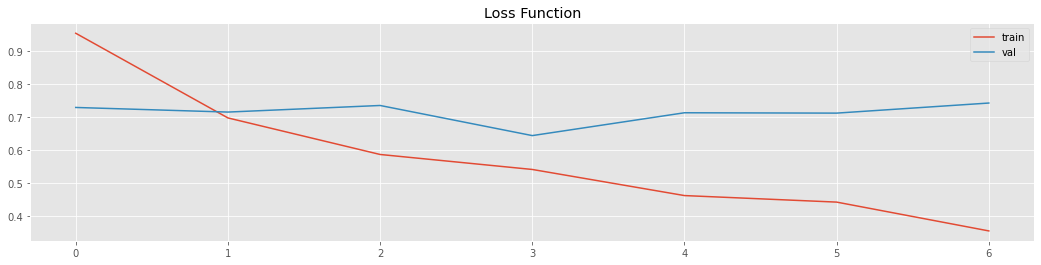

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['loss'], label = 'train')
plt.plot(data_his['val_loss'], label = 'val')
plt.legend()
plt.title('Loss Function')
plt.show()
fig.savefig("Loss Function",dpi=700)


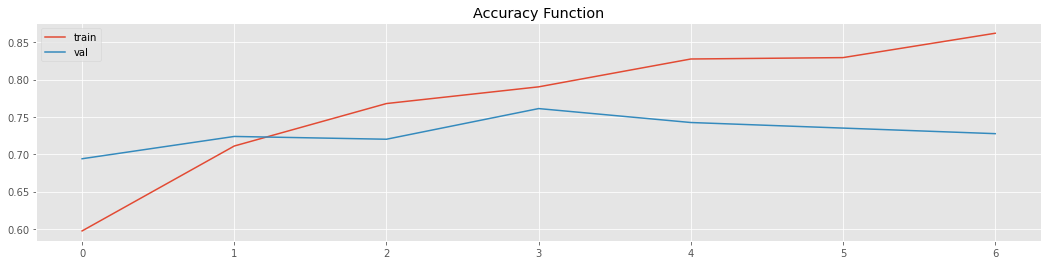

In [ ]:
fig = plt.figure(figsize=(18, 4))
plt.plot(data_his['accuracy'], label = 'train')
plt.plot(data_his['val_accuracy'], label = 'val')
plt.legend()
plt.title('Accuracy Function')
plt.show()
fig.savefig("Accuracy Function",dpi=700)

In [ ]:
train_images.class_indices.keys()

dict_keys(['autumn', 'spring', 'summer', 'winter'])

In [ ]:
train_images.class_indices.values()

dict_values([0, 1, 2, 3])

In [ ]:
model.save("/content/drive/MyDrive/2023 KUIAI 해커톤/woman_season_tag_classificator.h5")

# 모델 결과 검증 

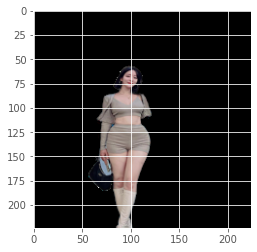

1/1 [==============================] - 0s 487ms/step
[2]


In [ ]:
from tensorflow.keras.preprocessing import image
dir_path = '/content/drive/MyDrive/2023 KUIAI 해커톤/influ_girl_half/@amourfor_u_2_half.png'

img = image.load_img(dir_path, target_size=(224,224))
plt.imshow(img)
plt.show()
    
X = image.img_to_array(img)
X = np.expand_dims(X,axis=0)
images = np.vstack([X])
predictions = np.argmax(model.predict(images), axis=1)
print(predictions)